Convert electron photon dataset from h5py files to single npz file with train test splitted

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement

In [4]:
def load_dataset():
    with h5py.File("/content/drive/My Drive/electron-photon-dataset/photon.hdf5", "r") as f:
        px = np.asarray(f['X'][()], dtype=np.float32)
        py = np.asarray(f['y'][()], dtype=np.float32)
        print("Loaded photon dataset!")

    with h5py.File("/content/drive/My Drive/electron-photon-dataset/electron.hdf5", "r") as f:
        ex = np.asarray(f['X'][()], dtype=np.float32)
        ey = np.asarray(f['y'][()], dtype=np.float32)
        print("Loaded electron dataset!")

    print("Photon dataset shape:", px.shape, py.shape)
    print("Electron dataset shape:", ex.shape, ey.shape)
    return px,py,ex,ey

In [ ]:
px,py,ex,ey = load_dataset()
print(px.shape, py.shape)
print(ex.shape, ey.shape)

Loaded photon dataset!
Loaded electron dataset!
Photon dataset shape: (249000, 32, 32, 2) (249000,)
Electron dataset shape: (249000, 32, 32, 2) (249000,)
(249000, 32, 32, 2) (249000,)
(249000, 32, 32, 2) (249000,)


In [ ]:
print(py.max(), py.min())
print(ey.max(), ey.min())

0.0 0.0
1.0 1.0


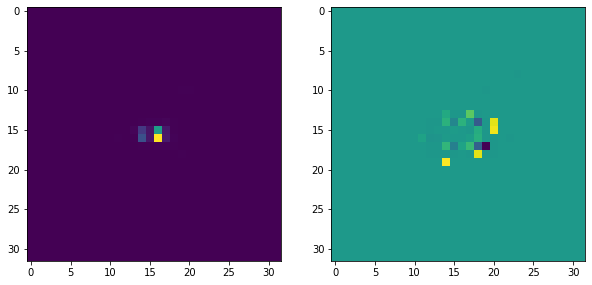

In [ ]:
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2
for i in range(columns):
    fig.add_subplot(rows, columns,i+1)
    plt.imshow(px[0,:,:,i])

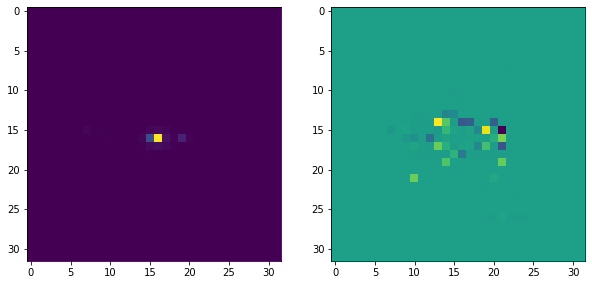

In [ ]:
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2
for i in range(columns):
    fig.add_subplot(rows, columns,i+1)
    plt.imshow(ex[0,:,:,i])

In [ ]:
x = np.concatenate((px,ex), axis =0)
y = np.concatenate((py,ey), axis= 0)
del px,ex,py,ey
print(x.shape)
print(y.shape)

(498000, 32, 32, 2)
(498000,)


In [ ]:
x, y = shuffle(x,y)

In [ ]:
print(x.max(),x.min())
print(y.max(),y.min())

2.2779698 -2.512557
1.0 0.0


In [ ]:
x.nbytes/(1024**2) + y.nbytes/(1024**2)

3892.5247192382812

In [ ]:
def reduce_memory_usage(x, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = x.nbytes/(1024**2)

    dtype = str(x.dtype)
    if dtype in numerics:
        c_min = x.min()
        c_max = x.max()

        if dtype[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                x = x.astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                x = x.astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                x = x.astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                x = x.astype(np.int64)
        else:
            if (
                c_min > np.finfo(np.float16).min
                and c_max < np.finfo(np.float16).max
            ):
                x = x.astype(np.float16)
            elif (
                c_min > np.finfo(np.float32).min
                and c_max < np.finfo(np.float32).max
            ):
                x = x.astype(np.float32)
            else:
                x = x.astype(np.float64)
    end_mem = x.nbytes/(1024**2)
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return x

In [ ]:
x = reduce_memory_usage(x)

Mem. usage decreased to 1945.31 Mb (50.0% reduction)


In [ ]:
y = reduce_memory_usage(y)

Mem. usage decreased to 0.95 Mb (50.0% reduction)


In [ ]:
print(x.shape)
print(y.shape)
x.nbytes/(1024**2) + y.nbytes/(1024**2)

(498000, 32, 32, 2)
(498000,)


1946.2623596191406

In [ ]:
print(x.max(),x.min())
print(y.max(),y.min())

2.277 -2.512
1.0 0.0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.15, random_state=42, stratify=y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
del x, y

(423300, 32, 32, 2) (423300,)
(74700, 32, 32, 2) (74700,)


In [ ]:
np.savez_compressed('/content/electron-photon-large.npz', **{
    'x_train': x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test
})

In [ ]:
del x_train, x_test, y_train, y_test

In [ ]:
data = np.load('/content/electron-photon-large.npz', allow_pickle=True)

Download the dataset from sidebar

In [ ]:
data['x_train'].shape

(423300, 32, 32, 2)

Preprocess electron photon

In [5]:
px,py,ex,ey = load_dataset()

Loaded photon dataset!
Loaded electron dataset!
Photon dataset shape: (249000, 32, 32, 2) (249000,)
Electron dataset shape: (249000, 32, 32, 2) (249000,)


In [6]:
def check_borders(x):
    # finding the left-most non-zero pixel coordinate 
    for i in range(x.shape[2]):
        if (x[:, :, i, 0].max() != 1) or (x[:, :, i, 1].max() != 0):
            border_left = i
            break

    # finding the right-most non-zero pixel coordinate 
    for i in range(x.shape[2]):
        if (x[:, :, x.shape[2]-1-i,0].max() != 0) or (x[:, :, x.shape[2]-1-i,1].max() != 0):
            border_right = x.shape[2]-1-i
            break

    # finding the top-most non-zero pixel coordinate 
    for i in range(x.shape[1]):
        if (x[:, i, :,0].max() != 0) or (x[:, i, :,1].max() != 0):
            border_top = i
            break

    # finding the bottom-most non-zero pixel coordinate 
    for i in range(x.shape[1]):
        if (x[:, x.shape[1]-1-i, :,0].max() != 0) or (x[:, x.shape[1]-1-i, :,1].max() != 0):
            border_bottom = x.shape[1]-1-i
            break

    print(border_left, border_right)
    print(border_top, border_bottom)

In [7]:
check_borders(px)

0 31
0 31


In [8]:
check_borders(ex)

0 31
0 31


Both training and testing datasets have non-zero pixels near the image's very edges, making it impossible to crop the image without information loss.

In [9]:
n_samples = 5000
n_population = px.shape[0]

samples = sample_without_replacement(n_population, n_samples)
px_sampled = px[samples][:,:,:,0].reshape(-1,32,32,1)
del px

n_population = ex.shape[0]
samples = sample_without_replacement(n_population, n_samples)
ex_sampled = ex[samples][:,:,:,0].reshape(-1,32,32,1)
del ex

In [10]:
py = [0]*n_samples
ey = [1]*n_samples

In [11]:
x = np.concatenate((px_sampled,ex_sampled), axis =0)
y = np.concatenate((py,ey), axis= 0)
del px_sampled,ex_sampled,py,ey
print(x.shape)
print(y.shape)

(10000, 32, 32, 1)
(10000,)


In [12]:
x, y = shuffle(x,y)

In [13]:
print(x.max(),x.min())
print(y.max(),y.min())

1.4745364 0.0
1 0


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state=42,stratify=y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
del x, y

(9000, 32, 32, 1) (9000,)
(1000, 32, 32, 1) (1000,)


In [15]:
np.savez_compressed('/content/electron-photon-med.npz', **{
    'x_train': x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test
})
del x_train, x_test, y_train, y_test

In [16]:
data = np.load('/content/electron-photon-med.npz', allow_pickle=True)

In [17]:
data['x_train'].shape

(9000, 32, 32, 1)

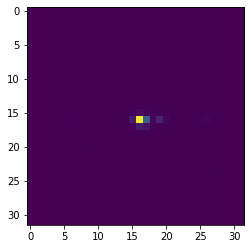

In [18]:
plt.imshow(data['x_train'][0][:,:,0].astype(np.float32))

In [ ]:
data['x_train'].dtype

dtype('float16')

In [ ]:
p